In [38]:
import librosa
import os
import keras
import numpy as np
import matplotlib.pyplot as plt
import math
from glob import glob

In [2]:
model_path = 'BirdNET-Analyzer/checkpoints/V2.3/BirdNET_GLOBAL_3K_V2.3_Model'
model = keras.models.load_model(model_path, compile=False).model

In [3]:
#audio_path = 'BirdNET-Analyzer/example/soundscape.wav'
audio_path = 'Merlin/2023-03-31 13_17.wav'
#audio_path = 'kaggle-data/train/7e0d06929.flac'
sig, _ = librosa.load(audio_path, 
            sr=48000, mono=True, res_type='kaiser_fast')
chunk_length = 3*48000
nchunks = len(sig) // chunk_length
chunks = sig[:nchunks*chunk_length].reshape(nchunks, chunk_length)

In [4]:
prediction = model.predict(chunks)

36/36 [==============================] - 41s 1s/step


In [5]:
sig2, sr2 = librosa.load('kaggle-data/train/00204008d.flac')
spectrum2 = librosa.feature.melspectrogram(
    y=sig2, sr=sr2, fmin=150, n_fft=512, 
    hop_length=130, n_mels=80, norm=100.0, power=0.5)

In [6]:
sig2

array([0.00439024, 0.00904919, 0.00429084, ..., 0.00030657, 0.00432516,
       0.00273107], dtype=float32)

In [55]:
spectrum2.shape

(80, 10177)

In [56]:
500*130/22050

2.947845804988662

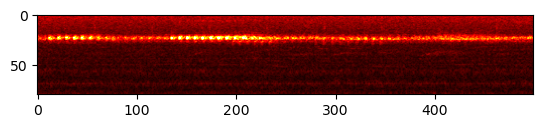

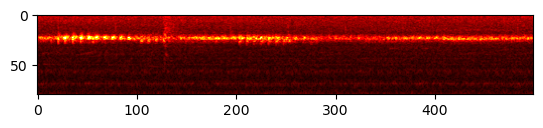

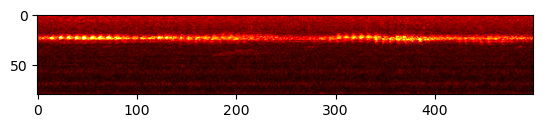

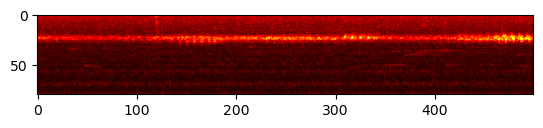

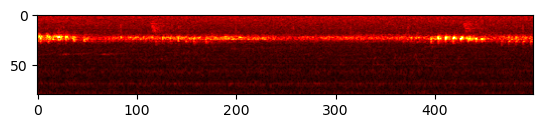

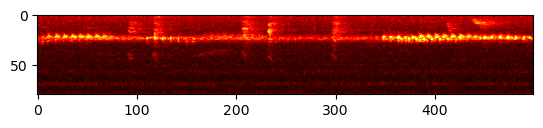

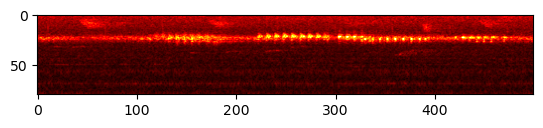

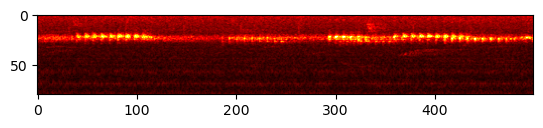

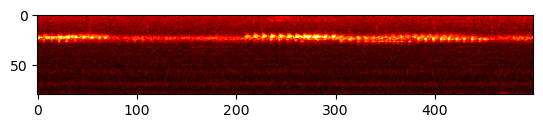

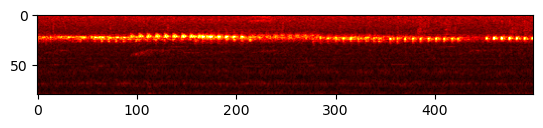

In [17]:
for i in range(10):
    plt.imshow(spectrum2[::-1,i*500:(i+1)*500], cmap='hot', vmin=0, vmax=4)
    plt.show()

In [18]:
sig3, sr3 = librosa.load('kaggle-data/train/009aa1c8f.flac')
spectrum3 = librosa.feature.melspectrogram(
    y=sig3, sr=sr3, fmin=150, n_fft=512, 
    hop_length=130, n_mels=80, norm=100.0, power=0.5)

In [19]:
spectrum3.shape

(80, 10177)

In [20]:
spectrum3[::-1].shape

(80, 10177)

In [21]:
from sklearn.decomposition import PCA

[0.8020909  0.05795319]


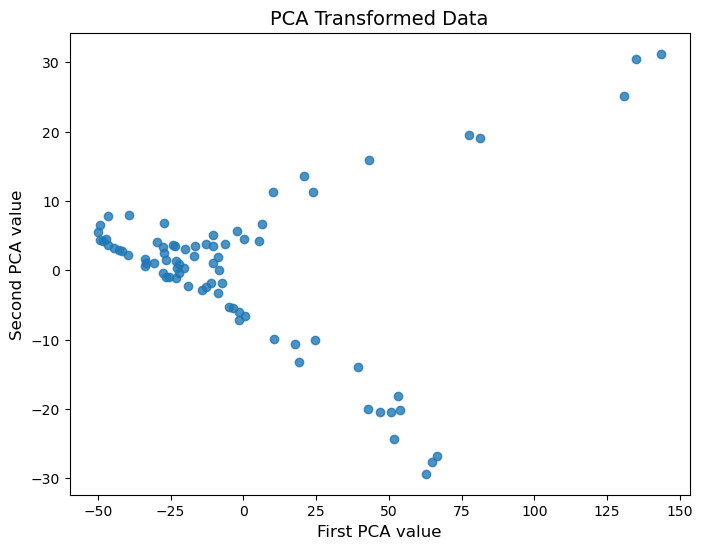

In [22]:
pca3 = PCA(2)

pca3.fit(spectrum3)

print(pca3.explained_variance_ratio_)

fit = pca3.transform(spectrum3)

plt.figure(figsize=(8,6))

plt.scatter(fit[:,0], fit[:,1], alpha=.8)

plt.xlabel("First PCA value", fontsize=12)
plt.ylabel("Second PCA value", fontsize=12)

plt.title("PCA Transformed Data", fontsize=14)

plt.show()

[0.8942839  0.02668601]


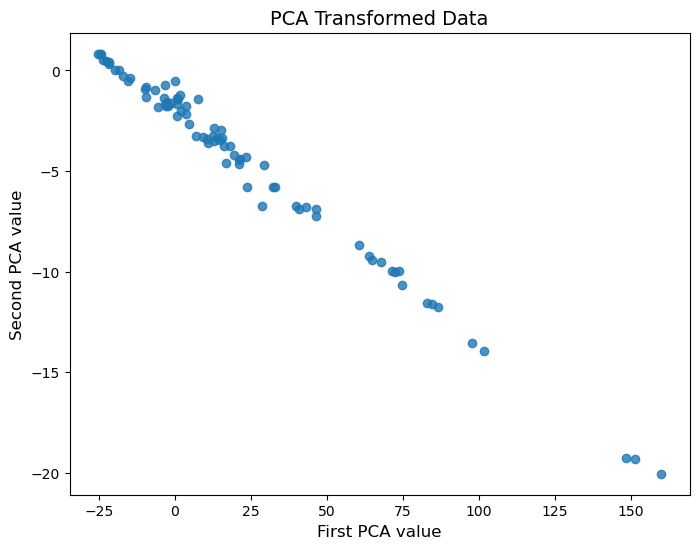

In [23]:
pca2 = PCA(2)

pca2.fit(spectrum2)

print(pca2.explained_variance_ratio_)

fit2 = pca2.transform(spectrum3)

plt.figure(figsize=(8,6))

plt.scatter(fit2[:,0], fit2[:,1], alpha=.8)

plt.xlabel("First PCA value", fontsize=12)
plt.ylabel("Second PCA value", fontsize=12)

plt.title("PCA Transformed Data", fontsize=14)

plt.show()

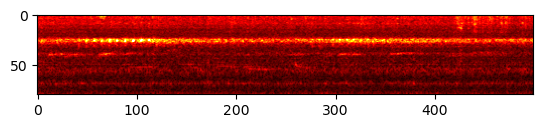

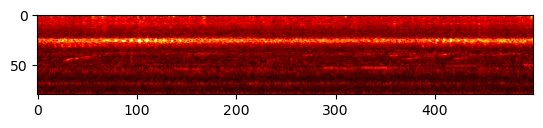

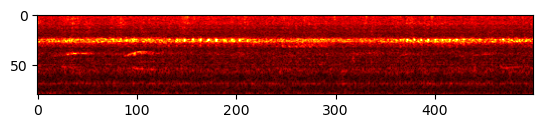

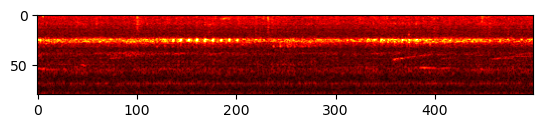

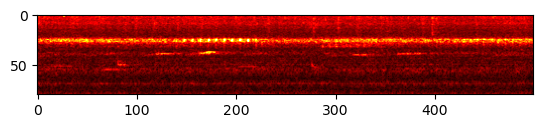

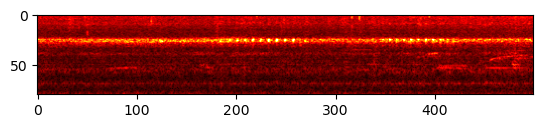

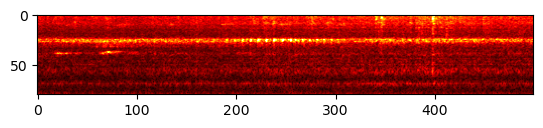

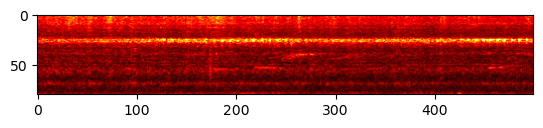

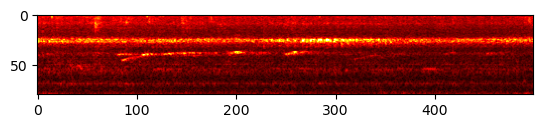

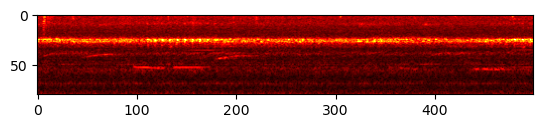

In [25]:
for i in range(10):
    plt.imshow(spectrum3[::-1,i*500:(i+1)*500], cmap='hot', vmin=0, vmax=4)
    plt.show()

In [26]:
import pandas as pd

In [27]:
train_fp = pd.read_csv('kaggle-data/train_fp.csv')
train_tp = pd.read_csv('kaggle-data/train_tp.csv')

In [28]:
train_tp.head(10)

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70
5,00b404881,8,1,0.0747,3750.000,4.1973,5531.25
6,00d442df7,0,1,19.3653,5906.250,20.1600,8250.00
7,011f25080,18,1,5.6853,3187.500,6.3787,5062.50
8,015113cad,15,1,50.0533,93.750,53.3973,1125.00
9,0151b7d20,1,1,46.0320,3843.750,46.9280,5625.00


In [36]:
train_fp.head(10)

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max
0,00204008d,21,1,13.8400,3281.2500,14.9333,4125.0000
1,00204008d,8,1,24.4960,3750.0000,28.6187,5531.2500
2,00204008d,4,1,15.0027,2343.7500,16.8587,4218.7500
3,003b04435,22,1,43.2533,10687.5000,44.8587,13687.5000
4,003b04435,23,1,9.1254,7235.1562,15.2091,11283.3984
5,005f1f9a5,10,1,49.3598,947.4609,51.8037,10852.7344
6,0072f0839,2,1,56.0053,468.7500,57.7813,3000.0000
7,0079ff47b,1,1,46.5653,3843.7500,47.4613,5625.0000
8,0079ff47b,11,1,49.0986,1808.7891,50.2364,5684.7656
9,0079ff47b,19,1,30.2240,281.2500,31.7760,2812.5000


In [29]:
len(train_tp)

1216

In [37]:
len(train_fp)+len(train_tp)

8997

In [39]:
def flat_sigmoid(x, sensitivity=-1):
    return 1 / (1.0 + np.exp(sensitivity * np.clip(x, -15, 15)))

model_path = 'BirdNET-Analyzer/checkpoints/V2.3/BirdNET_GLOBAL_3K_V2.3_Labels.txt'
with open(model_path) as f:
    labels = [l.replace('\n', '') for l in f.readlines()]

for p in prediction:
    p_labels = list(zip(labels, p))
    p_labels.sort(key = lambda x: x[1], reverse = True)
    #print([(b.split('_')[1], math.floor(flat_sigmoid(p)*100)) for b, p in p_labels if flat_sigmoid(p) >= 0.1])

In [32]:
intermediate_model = keras.Model(inputs = model.input, outputs = model.get_layer('MEL_SPEC').output)
spec = intermediate_model.predict(chunks)

36/36 [==============================] - 10s 265ms/step


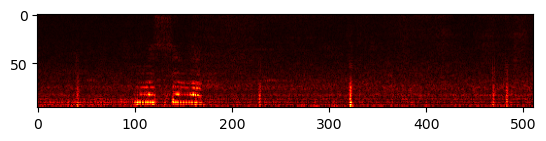

In [33]:
plt.imshow(spec[14,:], cmap='hot')

In [34]:
model.get_layer('MEL_SPEC').get_config()

{'name': 'MEL_SPEC',
 'trainable': True,
 'dtype': 'float32',
 'data_format': 'channels_last',
 'sample_rate': 48000,
 'spec_shape': [96, 512],
 'frame_step': 280,
 'fmin': 150,
 'fmax': 15000,
 'frame_length': 1024}

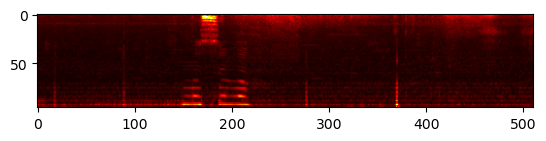

In [35]:
spec2 = librosa.feature.melspectrogram(y = sig, sr = 48000, 
    fmin=150, fmax=15000, n_fft=1024, hop_length=280, n_mels=96, norm=100.0, power=0.5)
plt.imshow(spec2[::-1,14*511:15*511], cmap='hot')

In [42]:
# glob creates a file path list of all of a certain filetype, in this case .flac.

flac_file_paths = list(glob("kaggle-data/train/" + "*.flac"))

print("Sample file paths:")

print(flac_file_paths[:3])
print(flac_file_paths[-3:])

Sample file paths:
['kaggle-data/train/87a34209d.flac', 'kaggle-data/train/f9e3b11ad.flac', 'kaggle-data/train/7ab53e433.flac']
['kaggle-data/train/e81c4f94c.flac', 'kaggle-data/train/84fa3be7e.flac', 'kaggle-data/train/8ffe19a69.flac']


In [43]:
# add variables song duration and freq range 

train_tp["song_duration"] = train_tp["t_max"] - train_tp["t_min"]

train_tp["freq_range"] = train_tp["f_max"] - train_tp["f_min"]

train_tp.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,song_duration,freq_range
0,003bec244,14,1,44.5440,2531.250,45.1307,5531.25,0.5867,3000.000
1,006ab765f,23,1,39.9615,7235.160,46.0452,11283.40,6.0837,4048.240
2,007f87ba2,12,1,39.1360,562.500,42.2720,3281.25,3.1360,2718.750
3,0099c367b,17,4,51.4206,1464.260,55.1996,4565.04,3.7790,3100.780
4,009b760e6,10,1,50.0854,947.461,52.5293,10852.70,2.4439,9905.239


In [59]:
spec17 = train_tp[train_tp['species_id']==17]
print(spec17)

     recording_id  species_id  songtype_id    t_min    f_min    t_max  \
3       0099c367b          17            4  51.4206  1464.26  55.1996   
24      04d6b1fc1          17            4   4.7307  1406.25   7.3387   
55      0c448e77c          17            4  36.2638  1464.26  40.0428   
56      0c48ed342          17            1  50.0320  1312.50  56.4853   
57      0c936a1d4          17            4  48.2453  1406.25  50.8533   
...           ...         ...          ...      ...      ...      ...   
1020    d59d099b3          17            1  37.0933  1312.50  43.5467   
1021    d59d099b3          17            1  41.0880  1312.50  47.5413   
1022    d59d099b3          17            4  36.0267  1406.25  38.6347   
1153    ee3dc0bc6          17            1  42.8533  1312.50  49.3067   
1154    ee3dc0bc6          17            1  47.0720  1312.50  53.5253   

        f_max  song_duration  freq_range  
3     4565.04         3.7790     3100.78  
24    3937.50         2.6080     2531

In [60]:
train_tp[train_tp['songtype_id']==4]

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,song_duration,freq_range
3,0099c367b,17,4,51.4206,1464.26,55.1996,4565.04,3.7790,3100.78
18,0313e82cf,16,4,21.4720,3093.75,23.3067,4593.75,1.8347,1500.00
19,03b96f209,16,4,30.9333,3093.75,32.7680,4593.75,1.8347,1500.00
20,03b96f209,16,4,49.6320,3093.75,51.4667,4593.75,1.8347,1500.00
24,04d6b1fc1,17,4,4.7307,1406.25,7.3387,3937.50,2.6080,2531.25
...,...,...,...,...,...,...,...,...,...
1170,f33a1793f,16,4,8.3147,3093.75,10.1493,4593.75,1.8346,1500.00
1179,f5889157c,16,4,53.0400,3093.75,54.8747,4593.75,1.8347,1500.00
1187,f84b8c8d3,23,4,1.1958,6459.96,9.1196,11627.90,7.9238,5167.94
1190,f8c661973,16,4,18.2347,3093.75,20.0693,4593.75,1.8346,1500.00


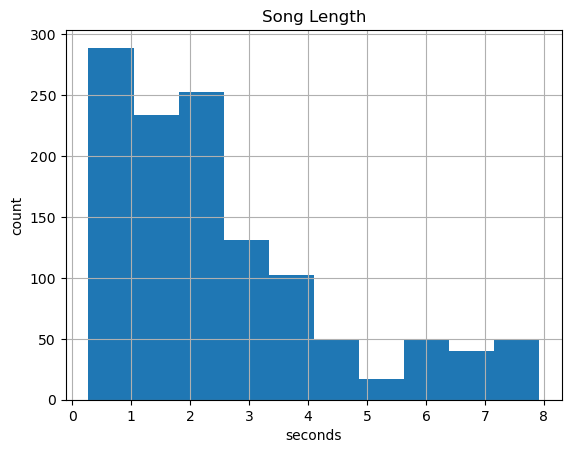

0.27199999999999847
7.923900000000003


In [52]:
# plot historgram of song duration

train_tp["song_duration"].hist()

plt.xlabel('seconds')
plt.ylabel('count')

plt.title("Song Length")

plt.show()


print(train_tp['song_duration'].min())
print(train_tp['song_duration'].max())

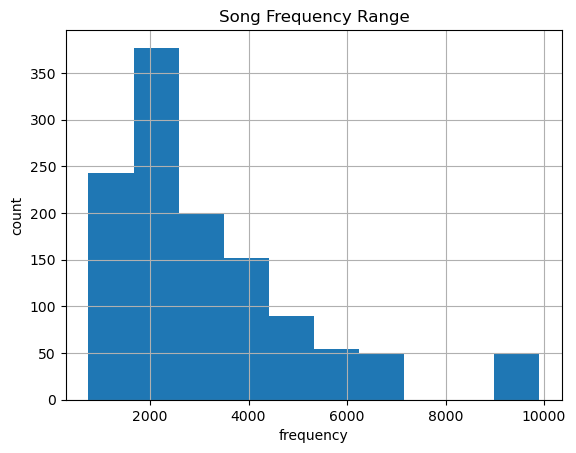

750.0
9905.239000000001


In [53]:
# plot historgram of song frequency range

train_tp['freq_range'].hist()

plt.xlabel('frequency')
plt.ylabel('count')
plt.title("Song Frequency Range")

plt.show()

print(train_tp['freq_range'].min())
print(train_tp['freq_range'].max())

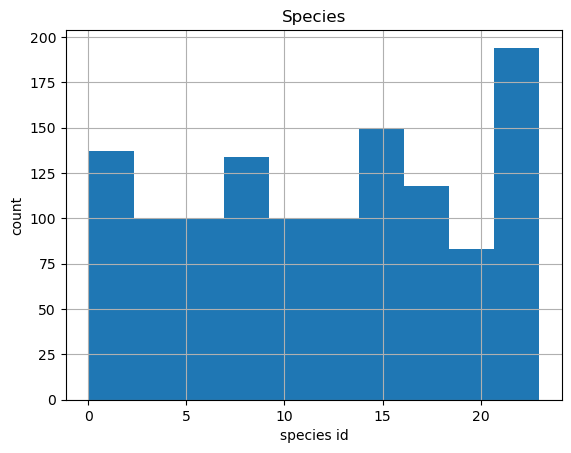

0
23


In [54]:
# plot historgram of species apprearing in TP training

train_tp['species_id'].hist()

plt.xlabel('species id')
plt.ylabel('count')

plt.title("Species")

plt.show()

print(train_tp['species_id'].min())
print(train_tp['species_id'].max())

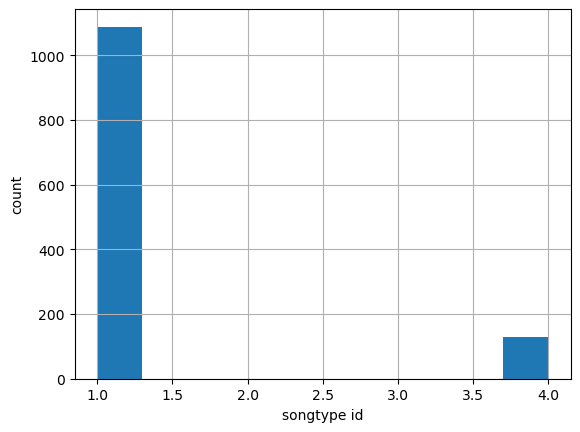

1
4


In [51]:
# plot historgram of song type apprearing in TP training

train_tp['songtype_id'].hist()

plt.xlabel('songtype id')
plt.ylabel('count')

plt.show()

print(train_tp['songtype_id'].min())
print(train_tp['songtype_id'].max())

In [47]:
from tqdm import tqdm

In [49]:
# testing with just 10 spectograms, but you can do by looping with 'using all_iters'

show_specs = False
save_dir = "/kaggle-data/spectograms/"
base_dir = '/kaggle-data/train/'

skipped = []

all_iters = len(train_tp)
just_ten = 5

process_these = just_ten

print(f"processing {process_these} files")

for i in tqdm(range(process_these)):
    
    
    try:
        this_row = train_tp.iloc[i]

        this_filename = base_dir + str(this_row.recording_id) + ".flac"

        print("processing: ", this_row.recording_id)

        # Important information about centering the audio array.
        song_start = this_row["t_min"]
        song_end = this_row["t_max"]
        song_duration = song_end - song_start
        clip_length = 10
        empty_space = clip_length - song_duration
        empty_space_one_side = (empty_space / 2)
        empty_offset = song_start - empty_space_one_side

        # Read in file
        audio_array, sampling_rate = lr.load(this_filename, duration=10,offset = empty_offset)

        # Use this to see when the spectrogram is being extracted.
        # print(empty_offset, song_start, song_end, song_end + empty_space_one_side)

        # Create the Fourier Transform 
        # (which isolates the amplitude level at each frequency)
        X_spec = librosa.stft(audio_array,n_fft = 1024)

        # Converted to Decibels
        spec_db = librosa.core.amplitude_to_db(X_spec)

        if show_specs:
            # Display the spectrogram
            ax = librosa.display.specshow(spec_db)
            plt.colorbar()
            plt.show()

        ax = librosa.display.specshow(spec_db)
        
        pic_filename = str(this_row.recording_id) + "_idx_" + str(i) + "_.png"
        new_save_filename = save_dir + pic_filename
        
        # print(new_save_filename)
        
        plt.savefig(new_save_filename, pad_inches = 0, bbox_inches = 'tight')

        plt.close("all")
        librosa.cache.clear()

    except:
        try:
            skipped.append(base_filename)
        except:
            pass
    
print("skipped: ", skipped)

processing 5 files


100%|██████████| 5/5 [00:00<00:00, 4408.56it/s]

processing:  003bec244
processing:  006ab765f
processing:  007f87ba2
processing:  0099c367b
processing:  009b760e6
skipped:  []


In [61]:
from sklearn.model_selection import train_test_split

In [62]:
train, test = train_test_split(train_tp,
                               random_state = 321,
                               shuffle = True,
                               test_size = 0.10)

In [63]:
train.head()

,recording_id,species_id,songtype_id,t_min,f_min,t_max,f_max,song_duration,freq_range
599,7859fda05,23,4,51.5251,6459.96,59.4489,11627.90,7.9238,5167.94
658,8574d9e81,14,1,27.8720,2812.50,28.7947,4406.25,0.9227,1593.75
926,c245b2295,9,1,50.3573,843.75,53.9200,5718.75,3.5627,4875.00
743,9bdc79a14,5,1,30.4907,4781.25,32.8427,10406.20,2.3520,5624.95
564,72ccf4de7,20,1,36.9813,2343.75,40.4213,5718.75,3.4400,3375.00


In [64]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [98]:
cols = ['songtype_id', 'species_id', 'recording_id', 'song_duration', 'freq_range']

In [99]:
## Make the PCA Pipeline here
pipe = Pipeline([('scale', StandardScaler()),
                 ('pca', PCA(2))])

## Fit the PCA here
pipe.fit(train.drop(columns = cols))

## Get the transformed training data here
## Store it in the variable fit provided below
fit = pipe.transform(train.drop(columns = cols))

In [100]:
fit

array([[-1.48313667,  2.50545419],
       [ 0.09554872, -0.39581504],
       [-1.83518428, -0.24443839],
       ...,
       [ 0.35710641,  1.53816364],
       [-0.86579978, -1.22912496],
       [-1.94372426,  0.5710638 ]])

In [101]:
from matplotlib.pyplot import cm

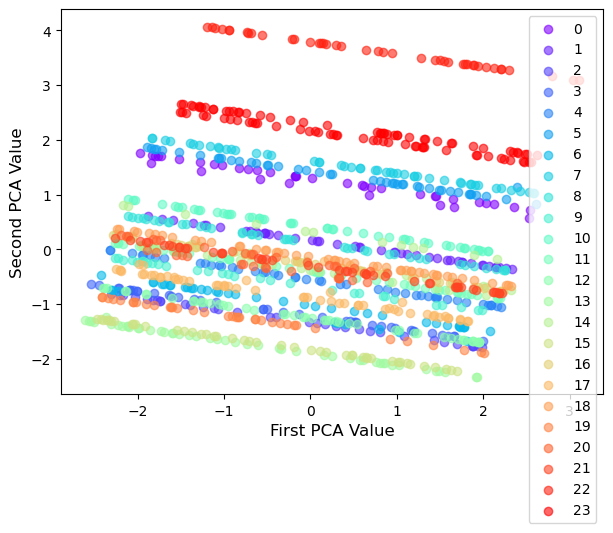

In [102]:
## This code will help you plot the two classes
plt.figure(figsize=(7,5))

color = cm.rainbow(np.linspace(0, 1, 24))

for i, c in zip(range(24), color):
    ## Plot y=0 class here
    plt.scatter(fit[train.species_id == i, 0], 
                fit[train.species_id == i, 1],
                color = c,
                label=str(i),
                alpha=.6)

plt.legend(fontsize=10)

plt.xlabel("First PCA Value", fontsize=12)
plt.ylabel("Second PCA Value", fontsize=12)

plt.show()

In [77]:
## Import what you need here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [78]:
## Make the kfold object here
kfold = KFold(n_splits = 5,
              shuffle=True,
              random_state= 423)

In [86]:
## Fill in the missing code below to run the cross validation
ks = range(1, 51)

## Make an array to hold the accuracies
pca_2_accs = np.zeros((5, len(ks)))

i = 0
for train_index, test_index in kfold.split(train, train.species_id):
    ## This will help you keep track of the loop progress
    print("CV Split", i)
    tt = train.iloc[train_index]
    ho = train.iloc[test_index]
    
    
    ## Note, putting the PCA here speeds up the loop
    ## Make the PCA pipeline
    pca_pipe = Pipeline([('scale', StandardScaler()),
                         ('pca', PCA(2))])
    
    ## Fit and then get the PCA transformed tt data here
    pca_tt = pca_pipe.fit_transform(tt.drop(columns = cols).values)
    
    ## Get the transformed holdout data here
    pca_ho = pca_pipe.transform(ho.drop(columns = cols).values)
    
    j = 0
    for k in ks:
        ## Define the KNN model here
        knn = KNeighborsClassifier(n_neighbors=k)
        
        ## Fit the knn model
        knn.fit(pca_tt, tt['species_id'])
        
        ## Get the prediction on the holdout data
        pred = knn.predict(pca_ho)
        
        ## Records the accuracy
        pca_2_accs[i,j] = accuracy_score(ho.species_id.values, pred)
        
        j = j + 1
    i = i + 1

CV Split 0
CV Split 1
CV Split 2
CV Split 3
CV Split 4


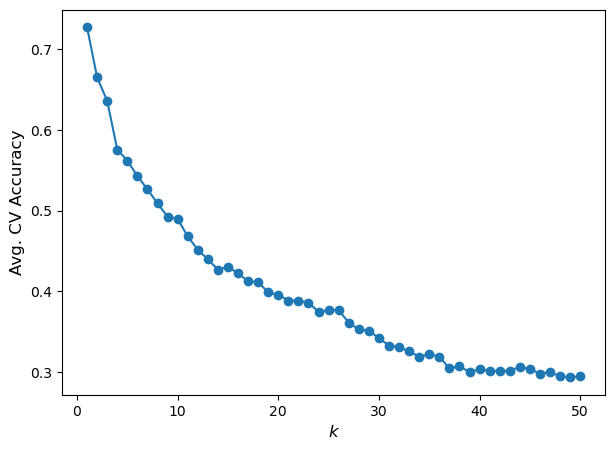

In [87]:
## Will plot the avg cv accuracy as a function of k
plt.figure(figsize=(7,5))


plt.plot(ks, 
         np.mean(pca_2_accs, axis=0),
         '-o')


plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("$k$", fontsize=12)
plt.ylabel("Avg. CV Accuracy", fontsize=12)

plt.show()

In [88]:
ks = range(1, 11)
comps = range(2,6)
n_splits = 5
## Makes a 3-D array of to record the accuracies in
pca_accs = np.zeros((n_splits, len(comps), len(ks)))

i = 0
for train_index, test_index in kfold.split(train, train.species_id):
    ## Keeps track of the cross validation split you are on
    ## This loop can be a little long
    print("CV Split", i)
    tt = train.iloc[train_index]
    ho = train.iloc[test_index]
    
    j = 0
    for n_comps in comps:
        ## Make the PCA pipeline here
        pca_pipe = Pipeline([('scale', StandardScaler()),
                            ('pca', PCA(n_comps))])
        
        ## Fit and then get the PCA transformed tt data here
        pca_tt = pca_pipe.fit_transform(tt.drop(columns = cols).values)
        
        ## Get the transformed holdout data here
        pca_ho = pca_pipe.transform(ho.drop(columns = cols).values)
        
        k = 0
        for neighbors in ks:
            knn = KNeighborsClassifier(neighbors)
            
            ## Fit on the tt data
            knn.fit(pca_tt, tt['species_id'])

            ## Get the holdout prediction
            pred = knn.predict(pca_ho)

            pca_accs[i,j,k] = accuracy_score(ho.species_id.values, pred)
            
            k = k + 1
        j = j + 1
    i = i + 1

CV Split 0
CV Split 1
CV Split 2
CV Split 3
CV Split 4


In [89]:
## This code will print out the best # components - k combo for you
## It also prints out the highest AVG CV Accuracy
max_index = np.unravel_index(np.argmax(np.mean(pca_accs, axis=0), axis=None), 
                                       np.mean(pca_accs, axis=0).shape)


print("The pair with the highest AVG CV Accuracy was",
         "k =", ks[max_index[1]],
         "and number of components =", np.round(comps[max_index[0]],2))
print("The highest AVG CV Accuracy was", np.max(np.mean(pca_accs, axis=0)))

The pair with the highest AVG CV Accuracy was k = 1 and number of components = 4
The highest AVG CV Accuracy was 0.9734740898998785


In [90]:
## import LinearSVC
from sklearn.svm import LinearSVC

In [92]:
## make model
## For now please ignore C=1000 we will touch on it next,
## max_iter=100000 just increases the number of iterations for the fitting algorithm
max_margin = LinearSVC(C=1000,
                       max_iter=100000)

## fit model
max_margin.fit(train.drop(columns = cols), train.species_id)

/home/birdsong/.local/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, max_iter=100000)

In [103]:
s = np.array((5,2))

In [104]:
*s.shape

SyntaxError: can't use starred expression here (4014135648.py, line 1)